### Домашнее задание 4

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


**1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention**

In [2]:
df = pd.read_csv('m_data.csv', ',')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


**2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.**

In [3]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [4]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [5]:
df.replace({'treatment': {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}}, inplace=True)
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

**4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
recency          64000 non-null int64
history          64000 non-null float64
used_discount    64000 non-null int64
used_bogo        64000 non-null int64
zip_code         64000 non-null object
is_referral      64000 non-null int64
channel          64000 non-null object
treatment        64000 non-null int64
target           64000 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [7]:
df = pd.get_dummies(df, columns=['zip_code', 'channel'])

**3. сделать разбиение набора данных не тренировочную и тестовую выборки**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1),
                                                    df['target'],
                                                    test_size=0.3,
                                                    random_state=42)

**5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями**

In [9]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']

X_train.drop(columns='treatment', inplace=True)
X_test.drop(columns='treatment', inplace=True)

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

**Модель с признаком коммуникации**

In [10]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

**Модель с трансформацией таргета**

In [11]:
from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

C:\Users\Coolver\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  after removing the cwd from sys.path.


**с двумя независимыми моделями**

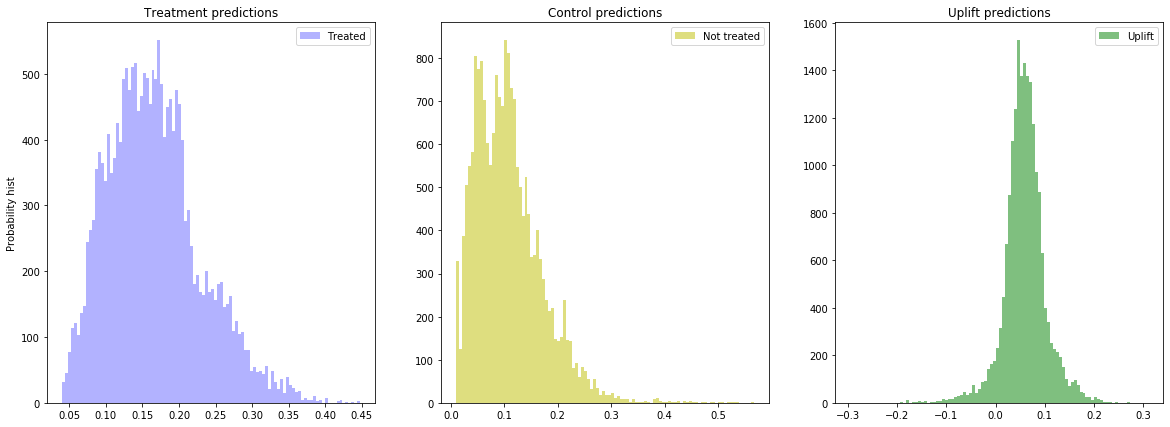

In [12]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

**6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей**

In [13]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.101838,0.095181
0,SoloModel,0.102578,0.084570
2,TwoModels,0.083775,0.081051


Модель с трансформацией показала наилучшие результаты.

**7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево**

In [ ]:
#!pip install causalml

Библиотека causalml не устанавливается, пробовала на двух разных машинах.

In [ ]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())